<a href="https://colab.research.google.com/github/Lucs1590/study_segmentation/blob/main/panoptic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Panoptic Segmentation

- We will use Detectron2 developed in PyTorch by [FAIR](https://ai.facebook.com/) (*Facebook AI Research*). We also will use DETR (DEtection TRansformer) to object detection task.

### Detectron2
- https://ai.facebook.com/tools/detectron2/ 
- [Github repository](https://github.com/facebookresearch/Detectron2)

### DETR
- https://arxiv.org/pdf/2005.12872.pdf 

# Libraries import

In [1]:
import io
import cv2
import math
import matplotlib.pyplot as plt
import requests
from PIL import Image

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
from copy import deepcopy
from google.colab.patches import cv2_imshow
torch.set_grad_enabled(False);

In [ ]:
#!pip install torch==1.9.0 torchvision==0.10.0
#import torch; print(torch.__version__)  #mostra versão
#!python -m pip install pip==21.3
#!pip --version #mostra versão

In [2]:
!pip install git+https://github.com/cocodataset/panopticapi.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-7q5qwkm8
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-7q5qwkm8


In [3]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [4]:
!git clone https://github.com/facebookresearch/detectron2.git
!pip install ./detectron2
!pip install --upgrade pyyaml

Cloning into 'detectron2'...
remote: Enumerating objects: 14481, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 14481 (delta 21), reused 35 (delta 14), pack-reused 14425
Receiving objects: 100% (14481/14481), 5.95 MiB | 14.89 MiB/s, done.
Resolving deltas: 100% (10467/10467), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./detectron2
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 50 kB 2.5 MB/s 
     |████████████████████████████████| 79 kB 6.5 MB/s 
     |████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!cp -r /content/gdrive/MyDrive/image-segmentation-course/fotos images/

# Normalization

- The standard method used by Pytorch to normalization is [mean-std](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html)
- mean = [0.485, 0.456, 0.406] 
- std = [0.229, 0.224, 0.225]

In [7]:
transform = T.Compose([T.Resize(800), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [8]:
transform

Compose(
    Resize(size=800, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

# Neural Networking Loading

In [9]:
model, postprocessor = torch.hub.load(
    'facebookresearch/detr',
    'detr_resnet101_panoptic',
    pretrained=True,
    return_postprocessor = True,
    num_classes=250
)

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth


  0%|          | 0.00/237M [00:00<?, ?B/s]

In [10]:
model

DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      

In [11]:
postprocessor

PostProcessPanoptic()

# Image Preparation

In [12]:
imagem = Image.open('images/garota-e-cachorro.jpg')
print(imagem)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x590 at 0x7FCC688EDC50>


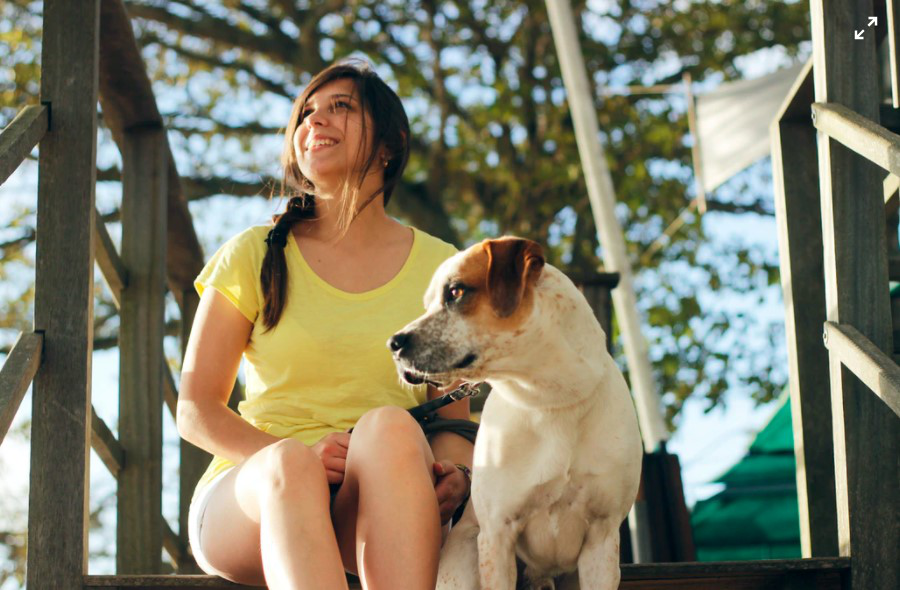

In [13]:
imagem

In [14]:
imagem.getpixel((0,0))

(153, 129, 93)

In [15]:
img = transform(imagem).unsqueeze(0)

In [16]:
img

tensor([[[[ 0.5022,  0.4337,  0.3138,  ..., -1.3987, -1.3644, -1.3473],
          [ 0.5364,  0.5022,  0.4166,  ..., -1.3987, -1.3644, -1.3302],
          [ 0.5536,  0.5536,  0.5193,  ..., -1.3987, -1.3644, -1.3302],
          ...,
          [ 1.0331,  1.2214,  1.4098,  ..., -1.7754, -1.7925, -1.7754],
          [ 1.2043,  1.3242,  1.4612,  ..., -1.7583, -1.7754, -1.7583],
          [ 1.3242,  1.3927,  1.4783,  ..., -1.7754, -1.7925, -1.7754]],

         [[ 0.2227,  0.1527,  0.0826,  ..., -1.1604, -1.1253, -1.1078],
          [ 0.2577,  0.2227,  0.1877,  ..., -1.1779, -1.1429, -1.1253],
          [ 0.2927,  0.2927,  0.3102,  ..., -1.1954, -1.1604, -1.1253],
          ...,
          [ 1.3957,  1.5882,  1.7808,  ..., -1.5105, -1.5280, -1.5105],
          [ 1.5007,  1.6408,  1.7983,  ..., -1.4930, -1.5105, -1.4930],
          [ 1.5707,  1.6583,  1.7808,  ..., -1.5105, -1.5280, -1.5105]],

         [[-0.1835, -0.2184, -0.2881,  ..., -1.1247, -1.0898, -1.0724],
          [-0.1487, -0.1835, -

# Segmentation

In [17]:
out = model(img)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [18]:
out

{'pred_boxes': tensor([[[0.8252, 0.2183, 0.1671, 0.2710],
          [0.8277, 0.7346, 0.0855, 0.1366],
          [0.4429, 0.4014, 0.8916, 0.8032],
          [0.3658, 0.4988, 0.7249, 0.9976],
          [0.3933, 0.9834, 0.7543, 0.0303],
          [0.6472, 0.7008, 0.4600, 0.5943],
          [0.8422, 0.2148, 0.1047, 0.2063],
          [0.1079, 0.9487, 0.2139, 0.0995],
          [0.5000, 0.4987, 0.9986, 0.9982],
          [0.8032, 0.7520, 0.1260, 0.1615],
          [0.1199, 0.4987, 0.2404, 0.9977],
          [0.4620, 0.4887, 0.9236, 0.9736],
          [0.9844, 0.0952, 0.0312, 0.1907],
          [0.6594, 0.8262, 0.5544, 0.3220],
          [0.7939, 0.8220, 0.2157, 0.2948],
          [0.7600, 0.4173, 0.4810, 0.8272],
          [0.6422, 0.9893, 0.1481, 0.0199],
          [0.4690, 0.8297, 0.9388, 0.3313],
          [0.5894, 0.4993, 0.8162, 0.9980],
          [0.4414, 0.4034, 0.8933, 0.8080],
          [0.4496, 0.4857, 0.9012, 0.9719],
          [0.4975, 0.7262, 0.0702, 0.1041],
          [0.8202,

In [19]:
out['pred_logits'].size()

torch.Size([1, 100, 251])

In [20]:
scores = out['pred_logits'].softmax(-1)[...,:-1].max(-1)[0]

In [21]:
scores

tensor([[2.7845e-02, 4.3183e-02, 6.1315e-02, 1.8186e-02, 3.1438e-03, 4.0431e-02,
         1.0576e-02, 2.9491e-03, 3.0989e-01, 1.8674e-01, 6.4491e-04, 1.0220e-01,
         3.2861e-02, 4.3825e-04, 1.3484e-03, 6.5558e-03, 7.5554e-03, 1.1396e-03,
         1.1403e-02, 3.9182e-01, 9.1167e-01, 3.9253e-03, 9.5923e-03, 1.2472e-01,
         8.9834e-02, 3.2820e-02, 1.0956e-02, 1.7961e-02, 3.9846e-02, 1.0294e-02,
         5.8986e-03, 9.3943e-01, 5.5009e-03, 4.1227e-03, 8.6886e-03, 1.9889e-03,
         1.9406e-03, 1.8939e-02, 7.1706e-03, 2.1549e-04, 2.1028e-01, 1.4896e-03,
         3.5506e-02, 9.9805e-01, 3.6176e-03, 3.7215e-02, 1.1963e-03, 7.4198e-01,
         1.7194e-02, 1.3001e-02, 5.6019e-03, 2.9230e-03, 5.9533e-03, 1.5375e-03,
         2.9066e-03, 6.9005e-02, 5.9764e-04, 6.4176e-03, 3.7078e-01, 4.0745e-02,
         1.2357e-02, 1.6935e-02, 3.5715e-04, 1.5084e-02, 4.3765e-03, 2.5078e-02,
         2.6111e-03, 4.3022e-03, 3.6263e-01, 2.4318e-03, 5.9761e-03, 1.4137e-02,
         4.8682e-04, 9.9878e

# Mask Returns

In [23]:
keep = scores > 0.85
print(keep)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
         False, False, False, False,  True, False, False, False, False, False]])


In [29]:
keep.sum().item()

6

In [30]:
math.ceil(keep.sum().item() / 5)

2

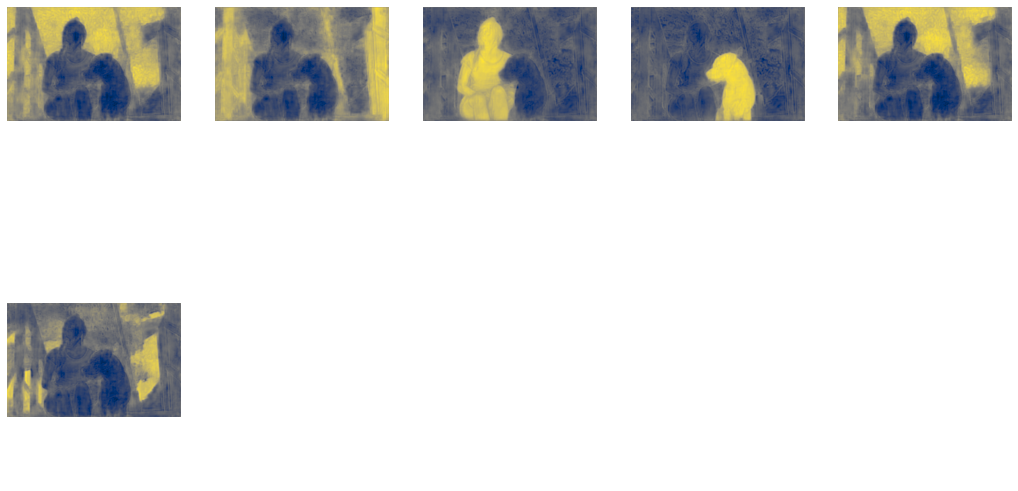

In [31]:
n_cols = 5
fig, axs = plt.subplots(ncols=n_cols, nrows=math.ceil(keep.sum().item() / n_cols), figsize=(18,10))
for line in axs:
  for a in line:
    a.axis('off')
for idx, mask in enumerate(out['pred_masks'][keep]):
  ax = axs[idx // n_cols, idx % n_cols]
  ax.imshow(mask, cmap='cividis')
  ax.axis('off')

# Segment Unification

In [32]:
img.shape, img.shape[-2:], torch.as_tensor(img.shape[-2:]).unsqueeze(0)[0]

(torch.Size([1, 3, 800, 1220]), torch.Size([800, 1220]), tensor([ 800, 1220]))

In [33]:
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

In [34]:
result

{'png_string': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xc4\x00\x00\x03 \x08\x02\x00\x00\x00C )\xb7\x00\x006qIDATx\x9c\xed\xdd\xe9r\xdb\xb8\x12\x06P\xc9\xf6\xfb?\xb1\x1d\xdf\x1f\x9a\xe8*Z(.X\xba\x81s*\x95r<\x1e\x9b\x96H\xb0?4H\x9eO\xd9\x9c{o\xc0\x18~{o\x00\x00\x14\xd7\xa5HpJ\x85\x8eD\x83\xbe>zo\x00\x00\x00\x00\xf9\x08\x93\x932\x8b\x03\x00\x00\x1c!L\x02\x00#\xe85Oj~\x16\xba8;\xfa\x02\x10&\x01\x80\xf4\xd4\x94\x00\xed\xe5\x0b\x93.s\x07\x00\x80\x99\x99?\n"_\x98\xa4\x14\x07!\x00\x00\xb0\x9b0\t\x00\x00d\xf2\xfb\xe2c\x1a\x13&\xa7\xa69\t\x00\xc79\x9fB{\xbf\x7f\xff\xd0\x9109;\xe7?\x00\x00R\x13){\x11&\x01\x00\x00\xd8,_\x98\xd4I+\xceK\n@jNd\x00]\xe4\x0b\x93\x00\x00\x00t\xf7\xd5{\x03\x08\xe1l\xad9\x00yhE\x02D\xa03\t\x00p\x88\tY\xe8\xcea\xd8\x850\xc9\x7f\xcc\xf2\x02\xc0V\x9eL\x00\xccL\x98\x04\x00\xd8L\x8c\x84h\x1c\x92\xed\t\x93\x00\x00\xdb\xa8Y\x01N\xc2$\xb7\xact\x05 \x05Y\x0ex\xca\xe0\xd0\x980\t\x00\x00\xc0f\xc2$\x00\x00\x00\x9b\xe5\x0b\x93\x9a\xd7\x00\x00\x00\xdd\xe5\x0b\x93T\xe5\xb2I\x0

In [35]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

In [37]:
panoptic_segmentation = Image.open(io.BytesIO(result['png_string']))
panoptic_segmentation = numpy.array(panoptic_segmentation, dtype=numpy.uint8).copy()
id_panoptic_segmentation = rgb2id(panoptic_segmentation)

In [42]:
panoptic_segmentation

array([[[ 31, 119, 180],
        [ 31, 119, 180],
        [ 31, 119, 180],
        ...,
        [255, 127,  14],
        [255, 127,  14],
        [255, 127,  14]],

       [[ 31, 119, 180],
        [ 31, 119, 180],
        [ 31, 119, 180],
        ...,
        [255, 127,  14],
        [255, 127,  14],
        [255, 127,  14]],

       [[ 31, 119, 180],
        [ 31, 119, 180],
        [ 31, 119, 180],
        ...,
        [255, 127,  14],
        [255, 127,  14],
        [255, 127,  14]],

       ...,

       [[255, 127,  14],
        [255, 127,  14],
        [255, 127,  14],
        ...,
        [255, 127,  14],
        [255, 127,  14],
        [255, 127,  14]],

       [[255, 127,  14],
        [255, 127,  14],
        [255, 127,  14],
        ...,
        [255, 127,  14],
        [255, 127,  14],
        [255, 127,  14]],

       [[255, 127,  14],
        [255, 127,  14],
        [255, 127,  14],
        ...,
        [255, 127,  14],
        [255, 127,  14],
        [255, 127,  14]]

In [38]:
id_panoptic_segmentation.shape

(800, 1220)

In [39]:
import numpy as np

In [40]:
id_panoptic_segmentation, np.unique(id_panoptic_segmentation, return_counts = True)

(array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int32),
 (array([0, 1, 2, 3, 4], dtype=int32),
  array([256136, 349284, 200014, 110230,  60336])))

(-0.5, 1219.5, 799.5, -0.5)

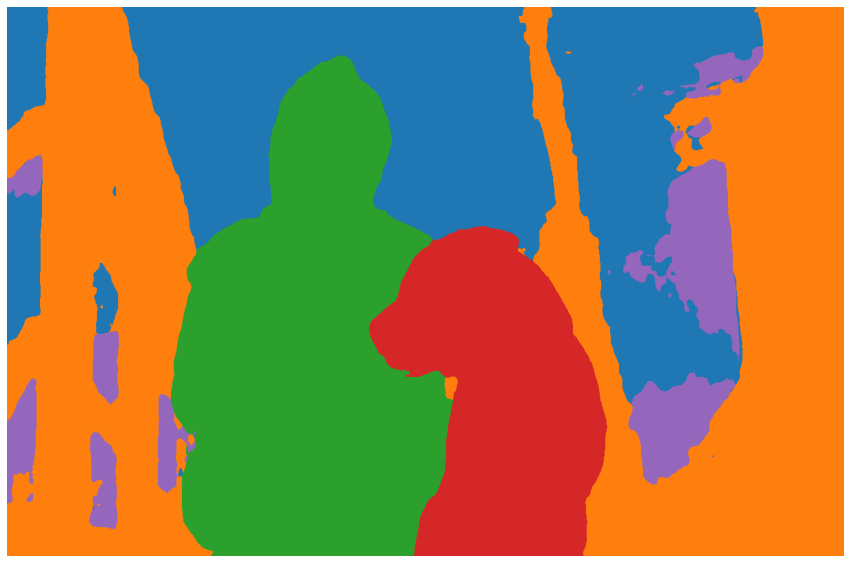

In [41]:
panoptic_segmentation[:,:,:] = 0
for id in range(id_panoptic_segmentation.max() + 1):
  panoptic_segmentation[id_panoptic_segmentation == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_segmentation)
plt.axis('off')

# Visualizing witht Detectron2

In [43]:
result['segments_info']

[{'area': 256136, 'category_id': 184, 'id': 0, 'isthing': False},
 {'area': 349284, 'category_id': 185, 'id': 1, 'isthing': False},
 {'area': 200014, 'category_id': 1, 'id': 2, 'isthing': True},
 {'area': 110230, 'category_id': 18, 'id': 3, 'isthing': True},
 {'area': 60336, 'category_id': 187, 'id': 4, 'isthing': False}]

In [44]:
# https://en.wikipedia.org/wiki/Object_copying#:~:text=Deep%20copy%20is%20a%20process,is%20copied%20in%20other%20object.
segment_info = deepcopy(result['segments_info'])

In [45]:
panoptic_seg = Image.open(io.BytesIO(result['png_string']))

In [46]:
final_w, final_h = panoptic_seg.size
print(final_w, final_h)

1220 800


In [47]:
panoptic_seg = numpy.asarray(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

In [48]:
meta = MetadataCatalog.get('coco_2017_val_panoptic_separated')
for idx in range(len(segment_info)):
  category = segment_info[idx]['category_id']
  #print(c)
  segment_info[idx]['category_id'] = meta.thing_dataset_id_to_contiguous_id[category] if segment_info[idx]['isthing'] else meta.stuff_dataset_id_to_contiguous_id[category]

In [49]:
segment_info

[{'area': 256136, 'category_id': 37, 'id': 0, 'isthing': False},
 {'area': 349284, 'category_id': 38, 'id': 1, 'isthing': False},
 {'area': 200014, 'category_id': 0, 'id': 2, 'isthing': True},
 {'area': 110230, 'category_id': 16, 'id': 3, 'isthing': True},
 {'area': 60336, 'category_id': 40, 'id': 4, 'isthing': False}]

In [50]:
classes_colors = meta.stuff_colors
classes_colors

[[82, 18, 128],
 [255, 255, 128],
 [147, 211, 203],
 [150, 100, 100],
 [168, 171, 172],
 [146, 112, 198],
 [210, 170, 100],
 [92, 136, 89],
 [218, 88, 184],
 [241, 129, 0],
 [217, 17, 255],
 [124, 74, 181],
 [70, 70, 70],
 [255, 228, 255],
 [154, 208, 0],
 [193, 0, 92],
 [76, 91, 113],
 [255, 180, 195],
 [106, 154, 176],
 [230, 150, 140],
 [60, 143, 255],
 [128, 64, 128],
 [92, 82, 55],
 [254, 212, 124],
 [73, 77, 174],
 [255, 160, 98],
 [255, 255, 255],
 [104, 84, 109],
 [169, 164, 131],
 [225, 199, 255],
 [137, 54, 74],
 [135, 158, 223],
 [7, 246, 231],
 [107, 255, 200],
 [58, 41, 149],
 [183, 121, 142],
 [255, 73, 97],
 [107, 142, 35],
 [190, 153, 153],
 [146, 139, 141],
 [70, 130, 180],
 [134, 199, 156],
 [209, 226, 140],
 [96, 36, 108],
 [96, 96, 96],
 [64, 170, 64],
 [152, 251, 152],
 [208, 229, 228],
 [206, 186, 171],
 [152, 161, 64],
 [116, 112, 0],
 [0, 114, 143],
 [102, 102, 156],
 [250, 141, 255]]

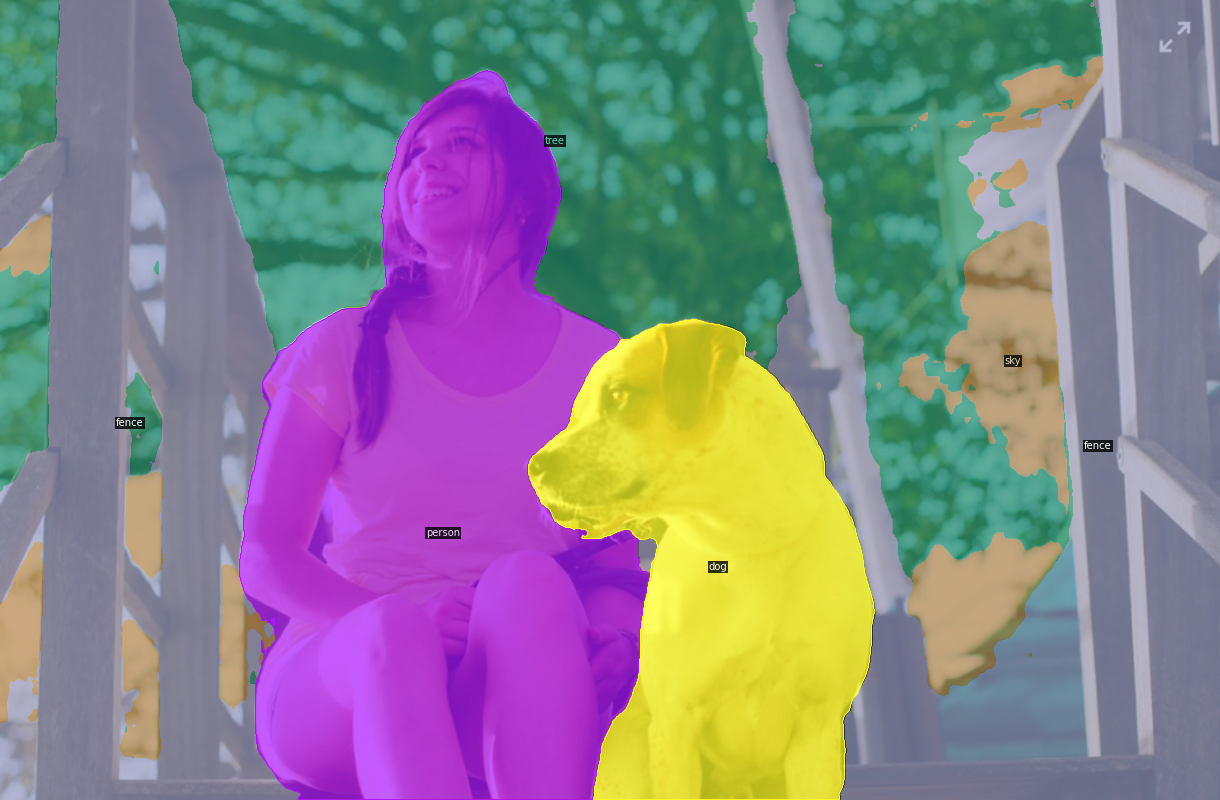

In [51]:
visualizer = Visualizer(numpy.array(imagem.copy().resize((final_w, final_h)))[:,:,::-1], meta, scale=1.0)
visualizer = visualizer.draw_panoptic_seg_predictions(panoptic_seg, segment_info)
resultado_final = visualizer.get_image()
cv2_imshow(resultado_final)